# Concept relevance propagation
In [*From attribution maps to human-understandable explanations through Concept Relevance Propagation*](https://www.nature.com/articles/s42256-023-00711-8) (CRP),
Achtibat et al. propose the conditioning of LRP relevances on individual features of a model.

This example builds on the basics shown in the *Getting started* section.
We start out by loading the same pre-trained LeNet5 model and MNIST input data:

In [1]:
using ExplainableAI
using Flux

using BSON # hide
model = BSON.load("../../model.bson", @__MODULE__)[:model] # hide
model

Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256 => 120, relu),              # 30_840 parameters
  Dense(120 => 84, relu),               # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 174.867 KiB.

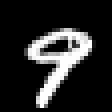

In [2]:
using MLDatasets
using ImageCore, ImageIO, ImageShow

index = 10
x, y = MNIST(Float32, :test)[10]
input = reshape(x, 28, 28, 1, :)

convert2image(MNIST, x)

## Step 1: Create LRP analyzer
To create a CRP analyzer, first define an LRP analyzer with your desired rules:

In [3]:
composite = EpsilonPlusFlat()
lrp_analyzer = LRP(model, composite)

LRP(
  Conv((5, 5), 1 => 6, relu)  => FlatRule(),
  MaxPool((2, 2))             => ZeroRule(),
  Conv((5, 5), 6 => 16, relu) => ZPlusRule(),
  MaxPool((2, 2))             => ZeroRule(),
  Flux.flatten                => PassRule(),
  Dense(256 => 120, relu)     => EpsilonRule{Float32}(1.0f-6),
  Dense(120 => 84, relu)      => EpsilonRule{Float32}(1.0f-6),
  Dense(84 => 10)             => EpsilonRule{Float32}(1.0f-6),
)

## Step 2: Define concepts
Then, specify the index of the layer on the outputs of which you want to condition the explanation.
In this example, we are interested in the outputs of the last convolutional layer, layer 3:

In [4]:
concept_layer = 3    # index of relevant layer in model
model[concept_layer] # show layer

Conv((5, 5), 6 => 16, relu)  # 2_416 parameters

Then, specify the concepts you are interested in.
To automatically select the $n$ most relevant concepts, use `TopNConcepts`.

Note that for convolutional layers,
a feature corresponds to an entire output channel of the layer.

In [5]:
concepts = TopNConcepts(5)

TopNConcepts(5)

To manually specify features, use `IndexedConcepts`.

In [6]:
concepts = IndexedConcepts(1, 2, 10)

IndexedConcepts(1, 2, 10)

## Step 3: Use CRP analyzer
We can now create a `CRP` analyzer
and use it like any other analyzer from ExplainableAI.jl:

,,

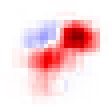
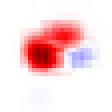
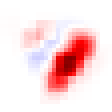

In [7]:
analyzer = CRP(lrp_analyzer, concept_layer, concepts)
heatmap(input, analyzer)

## Using CRP on input batches
Note that `CRP` uses the batch dimension to return explanations.
When using CRP on batches, the explanations are first sorted by concepts, then inputs,
e.g. `[c1_i1, c1_i2, c2_i1, c2_i2, c3_i1, c3_i2]` in the following example:

,,,,,

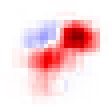
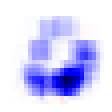
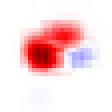
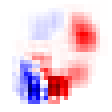
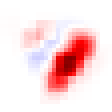
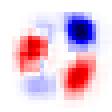

In [8]:
x, y = MNIST(Float32, :test)[10:11]
batch = reshape(x, 28, 28, 1, :)

heatmap(batch, analyzer)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*